In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall
import tensorflow.keras.backend as K
from tensorflow.keras.datasets import cifar10

# Define a custom F1 Score metric class
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.99  # Reduce learning rate by 1% after 10 epochs

# FFT preprocessing
def apply_fft(images):
    fft_images = []
    for img in images:
        # Apply FFT to each channel separately
        fft_img = np.fft.fft2(img, axes=(0, 1))  # 2D FFT along height and width
        fft_img = np.fft.fftshift(fft_img)  # Shift the zero-frequency component to the center
        fft_img = np.abs(fft_img)  # Use the magnitude of the FFT
        fft_images.append(fft_img)
    return np.array(fft_images)

# Create data generators for CIFAR-10
def create_data_generators(input_type='spatial'):
    # Load CIFAR-10 dataset
    (X_train, Y_train), (X_val, Y_val) = cifar10.load_data()

    # Normalize spatial inputs
    X_train = X_train.astype('float32') / 255.0
    X_val = X_val.astype('float32') / 255.0

    # Apply FFT transformation if specified
    if input_type == 'fft':
        X_train = apply_fft(X_train)
        X_val = apply_fft(X_val)

    # Convert labels to categorical (one-hot encoding)
    Y_train = tf.keras.utils.to_categorical(Y_train, 10)
    Y_val = tf.keras.utils.to_categorical(Y_val, 10)

    return (X_train, Y_train), (X_val, Y_val)

# Define the pre-trained ResNet model with fine-tuning
def create_pretrained_resnet(input_shape, num_classes, dropout_rate=0.3):
    # Load ResNet50 without the top (classification) layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the layers of ResNet50
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top of ResNet50
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(128, activation='relu')(x)  # Fully connected layer
    x = Dropout(dropout_rate)(x)  # Dropout for regularization

    # Output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the full model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with the required metrics, including F1Score
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall(), F1Score()])

    # Print the model summary
    model.summary()

    return model

# Training function for ResNet on CIFAR-10
def train_resnet_cifar10(input_type='spatial', batch_size=32, epochs=50):
    # Load CIFAR-10 data
    (X_train, Y_train), (X_val, Y_val) = create_data_generators(input_type)

    # Get input shape
    input_shape = X_train.shape[1:]

    # Number of classes
    num_classes = 10

    # Create the model
    model = create_pretrained_resnet(input_shape, num_classes)

    # Define callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True),
        ModelCheckpoint('best_resnet_model_cifar10.h5', monitor='val_loss', mode='min', save_best_only=True),
        LearningRateScheduler(lr_scheduler)
    ]

    # Train the model
    history = model.fit(X_train, Y_train,
                        validation_data=(X_val, Y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks)
    
    return history

# Run the training function in the Jupyter notebook
input_type = 'spatial'  # Choose 'spatial' or 'fft'
batch_size = 32
epochs = 50

# Train the model
history = train_resnet_cifar10(input_type=input_type, batch_size=batch_size, epochs=epochs)


2024-10-22 16:26:26.724489: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 16:26:26.725872: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 16:26:26.754337: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-22 16:26:26.754872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 16:26:27.195256: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

/home/cs/anaconda3/lib/python3.11/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


1563/1563 [==============================] - 62s 39ms/step - loss: 2.2376 - accuracy: 0.1462 - precision: 0.1000 - recall: 1.2000e-04 - f1_score: 2.3971e-04 - val_loss: 2.1496 - val_accuracy: 0.2050 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 2/50
1563/1563 [==============================] - 59s 38ms/step - loss: 2.1668 - accuracy: 0.1728 - precision: 1.0000 - recall: 2.0000e-05 - f1_score: 3.9999e-05 - val_loss: 2.0674 - val_accuracy: 0.2279 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 3/50
1563/1563 [==============================] - 59s 38ms/step - loss: 2.1418 - accuracy: 0.1860 - precision: 0.6000 - recall: 4.8000e-04 - f1_score: 9.5923e-04 - val_loss: 2.0411 - val_accuracy: 0.2531 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - lr: 0.0010
Epoch 4/50
1563/1563 [==============================] - 59s 38ms/step - loss: 2.1277 - accuracy: 0.189

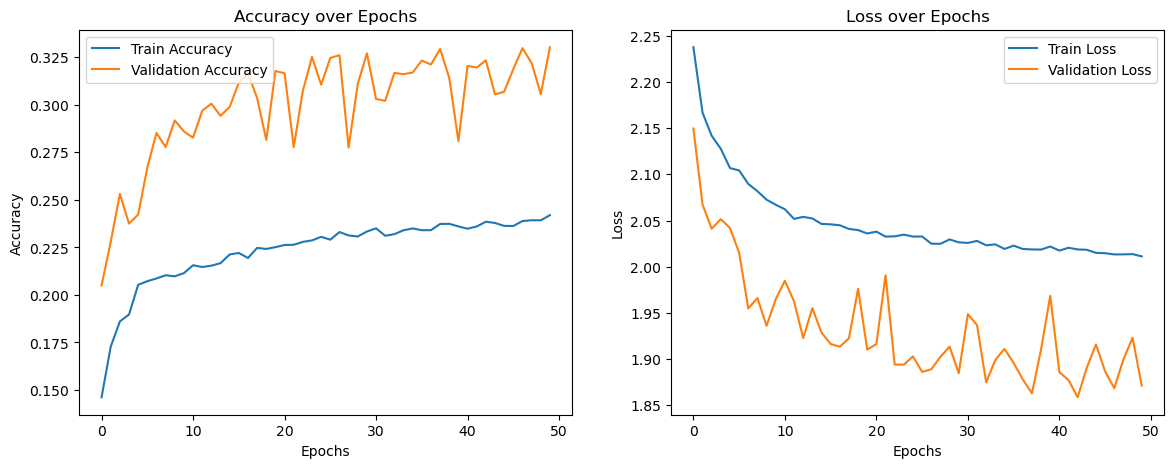

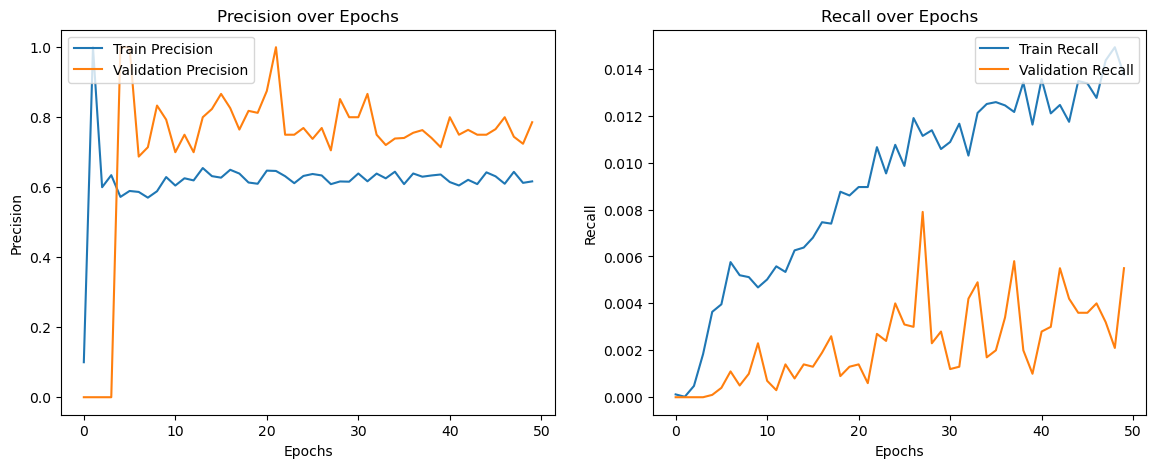

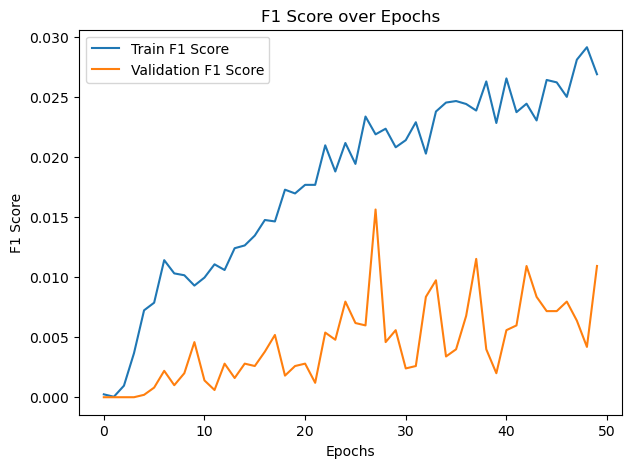

In [2]:
import matplotlib.pyplot as plt

# Function to plot training and validation curves
def plot_training_history(history):
    # Plot accuracy
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

    # Plot precision
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.title('Precision over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend(loc='upper left')

    # Plot recall
    plt.subplot(1, 2, 2)
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.title('Recall over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend(loc='upper right')

    plt.show()

    # Plot F1-score
    plt.figure(figsize=(7, 5))
    plt.plot(history.history['f1_score'], label='Train F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title('F1 Score over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend(loc='upper left')

    plt.show()

# Call the plot function after training
plot_training_history(history)


/home/cs/anaconda3/lib/python3.11/site-packages/keras/engine/training.py:2448: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


313/313 [==============================] - 11s 33ms/step - loss: 1.8588 - accuracy: 0.3234 - precision: 0.7639 - recall: 0.0055 - f1_score: 0.0109
Test Loss: 1.8588
Test Accuracy: 0.3234
Test Precision: 0.7639
Test Recall: 0.0055
Test F1 Score: 0.0109
313/313 [==============================] - 10s 32ms/step


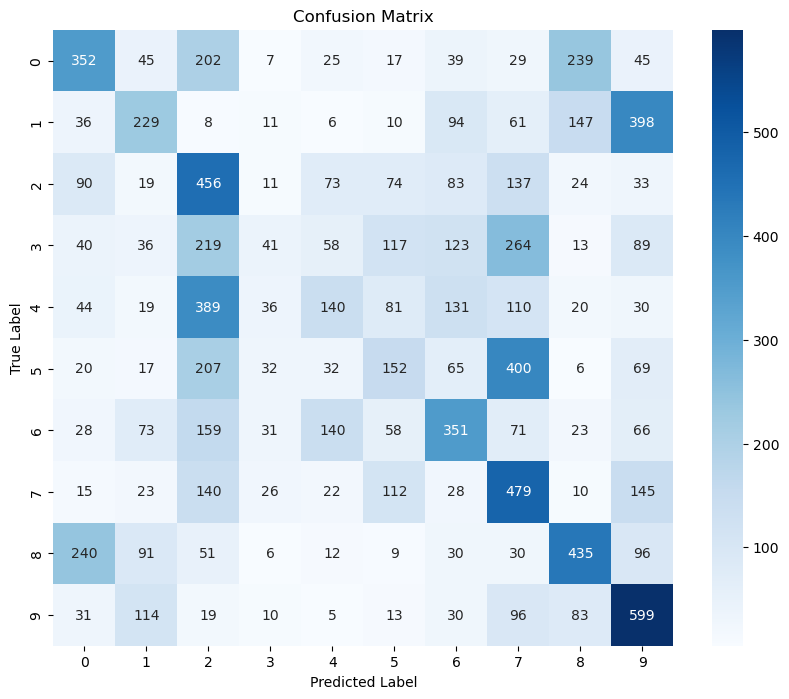


Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.35      0.37      1000
           1       0.34      0.23      0.27      1000
           2       0.25      0.46      0.32      1000
           3       0.19      0.04      0.07      1000
           4       0.27      0.14      0.19      1000
           5       0.24      0.15      0.19      1000
           6       0.36      0.35      0.36      1000
           7       0.29      0.48      0.36      1000
           8       0.43      0.43      0.43      1000
           9       0.38      0.60      0.47      1000

    accuracy                           0.32     10000
   macro avg       0.31      0.32      0.30     10000
weighted avg       0.31      0.32      0.30     10000



In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report

# Load the saved model
model = load_model('best_resnet_model_cifar10.h5', custom_objects={'F1Score': F1Score})

# Load CIFAR-10 test dataset
(_, _), (X_test, Y_test) = cifar10.load_data()

# Normalize the test data
X_test = X_test.astype('float32') / 255.0
Y_test_one_hot = tf.keras.utils.to_categorical(Y_test, 10)  # One-hot encode the labels

# Evaluate the model on test data
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(X_test, Y_test_one_hot, verbose=1)

# Print the evaluation metrics
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1_score:.4f}")

# Get predictions for the confusion matrix
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert one-hot predictions to class labels

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification report for precision, recall, f1-score for each class
print("\nClassification Report:\n", classification_report(Y_test, Y_pred_classes))
